This is the entry file to re-produce the data and figure in manuscript:

**"A Universal and Concise Framework for Driving Risk Estimation by Connecting Driving Risk to Potential Collision Damage"**

Python

# 0 - Import lib and matplotlib settings

In [4]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import copy
import pickle

import PODAR

In [5]:
# matplotlib settings

color_map1 = ['#2B65C2', '#f74d4d', '#E8940E', '#973FFF', '#35A800', '#002c53', '#41b7ac', '#943c39']
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.labelsize'] = 6 * 2.54  # 8 * 2.54
plt.rcParams['ytick.labelsize'] = 6 * 2.54  # 8 * 2.54
plt.rcParams['font.family'] = ['Times New Roman']
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['lines.linewidth'] = 1.2
plt.rcParams['lines.markersize'] = 8.0
plt.rcParams['lines.markerfacecolor'] =  'white' #'none'
plt.rcParams['legend.fontsize'] = 6 * 2.54  # 16
plt.rcParams['legend.edgecolor'] = 'None'
plt.rcParams['legend.facecolor'] = 'None'
plt.rcParams['axes.labelsize'] = 6 * 2.54  # 8 * 2.54
plt.rcParams['savefig.pad_inches'] = 0.05
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_map1)
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.facecolor'] = 'None'
plt.rcParams['axes.facecolor'] = 'None'
plt.rcParams['figure.dpi'] = 300

# 1 - model calibration

In [24]:
# load the data
with open(r'calibration_data.pkl', 'rb') as f:
    objective_data, ObjX, ObjY = pickle.load(f)  # steering angle during experiment, obstacles position


- objective_data: Dict[participant_id : steering_wheel_angle], the steering angle data for each participant when facing a obstacle
  - participant number = 8
  - steering_wheel_angle: np.ndarray, shape = (291, 308) = (drive distance, 77obs*4trial)
- ObjX, ObjY: coordinate of the obstacles, shpe = (77,)

In [50]:
# find the max steering angle values

def normalization(data):
    return data / np.max(data)

obj_data_raw = []  # shape = [8, 77]
use_lines = 25 # The first 1 second after the obstacle appears
for subID in range(8):
    objective_data[subID][np.abs(objective_data[subID]) <= 2] = 0
    obj_dataset = []
    for objID in range(77):
        st_angle = np.mean(np.max(np.abs(objective_data[subID][:use_lines,4*objID:4*objID+4]), 0))
        st_angle = 0 if st_angle <2 else st_angle
        obj_dataset.append(st_angle)
    obj_data_raw.append(copy.deepcopy(obj_dataset))

objective_data_by_obj = np.mean(np.array(obj_data_raw), axis=0)

In [68]:
# the best parameters: A=1.04, B=1.94, T=4, has been used in the PODAR model, see 'PODAR.py'
podar_est = []
for objID in range(77):
    x_obj, y_obj = ObjX[objID], ObjY[objID]
    vehicles_1 = PODAR.Vehicles()
    vehicles_1.set_ego(type='car', x0=0, y0=0, speed=25, phi0=0)
    vehicles_1.add_obj(type='car', x0=x_obj, y0=-y_obj, speed=0, phi0=np.pi, length=15, width=0.25)
    podar_risk, _, _ = vehicles_1.estimate_risk()

    podar_est.append(podar_risk)

# normalize the steering angle data into similar range as the PODAR value
scaled_steering = objective_data_by_obj * (np.max(podar_est) / np.max(objective_data_by_obj))

# calculat R2
label_mean = np.mean(scaled_steering)
sst = np.power((scaled_steering - label_mean), 2).sum()
ssr = np.power((np.array(podar_est) - scaled_steering), 2).sum()
r2 = 1 - ssr / sst
print("=============================================")
print("\033[31m Calibration results: R2 = {} \033[0m".format(r2))
print("=============================================")

 Calibration results: R2 = 0.9629619137859825 


#### [-] Fig. 3b

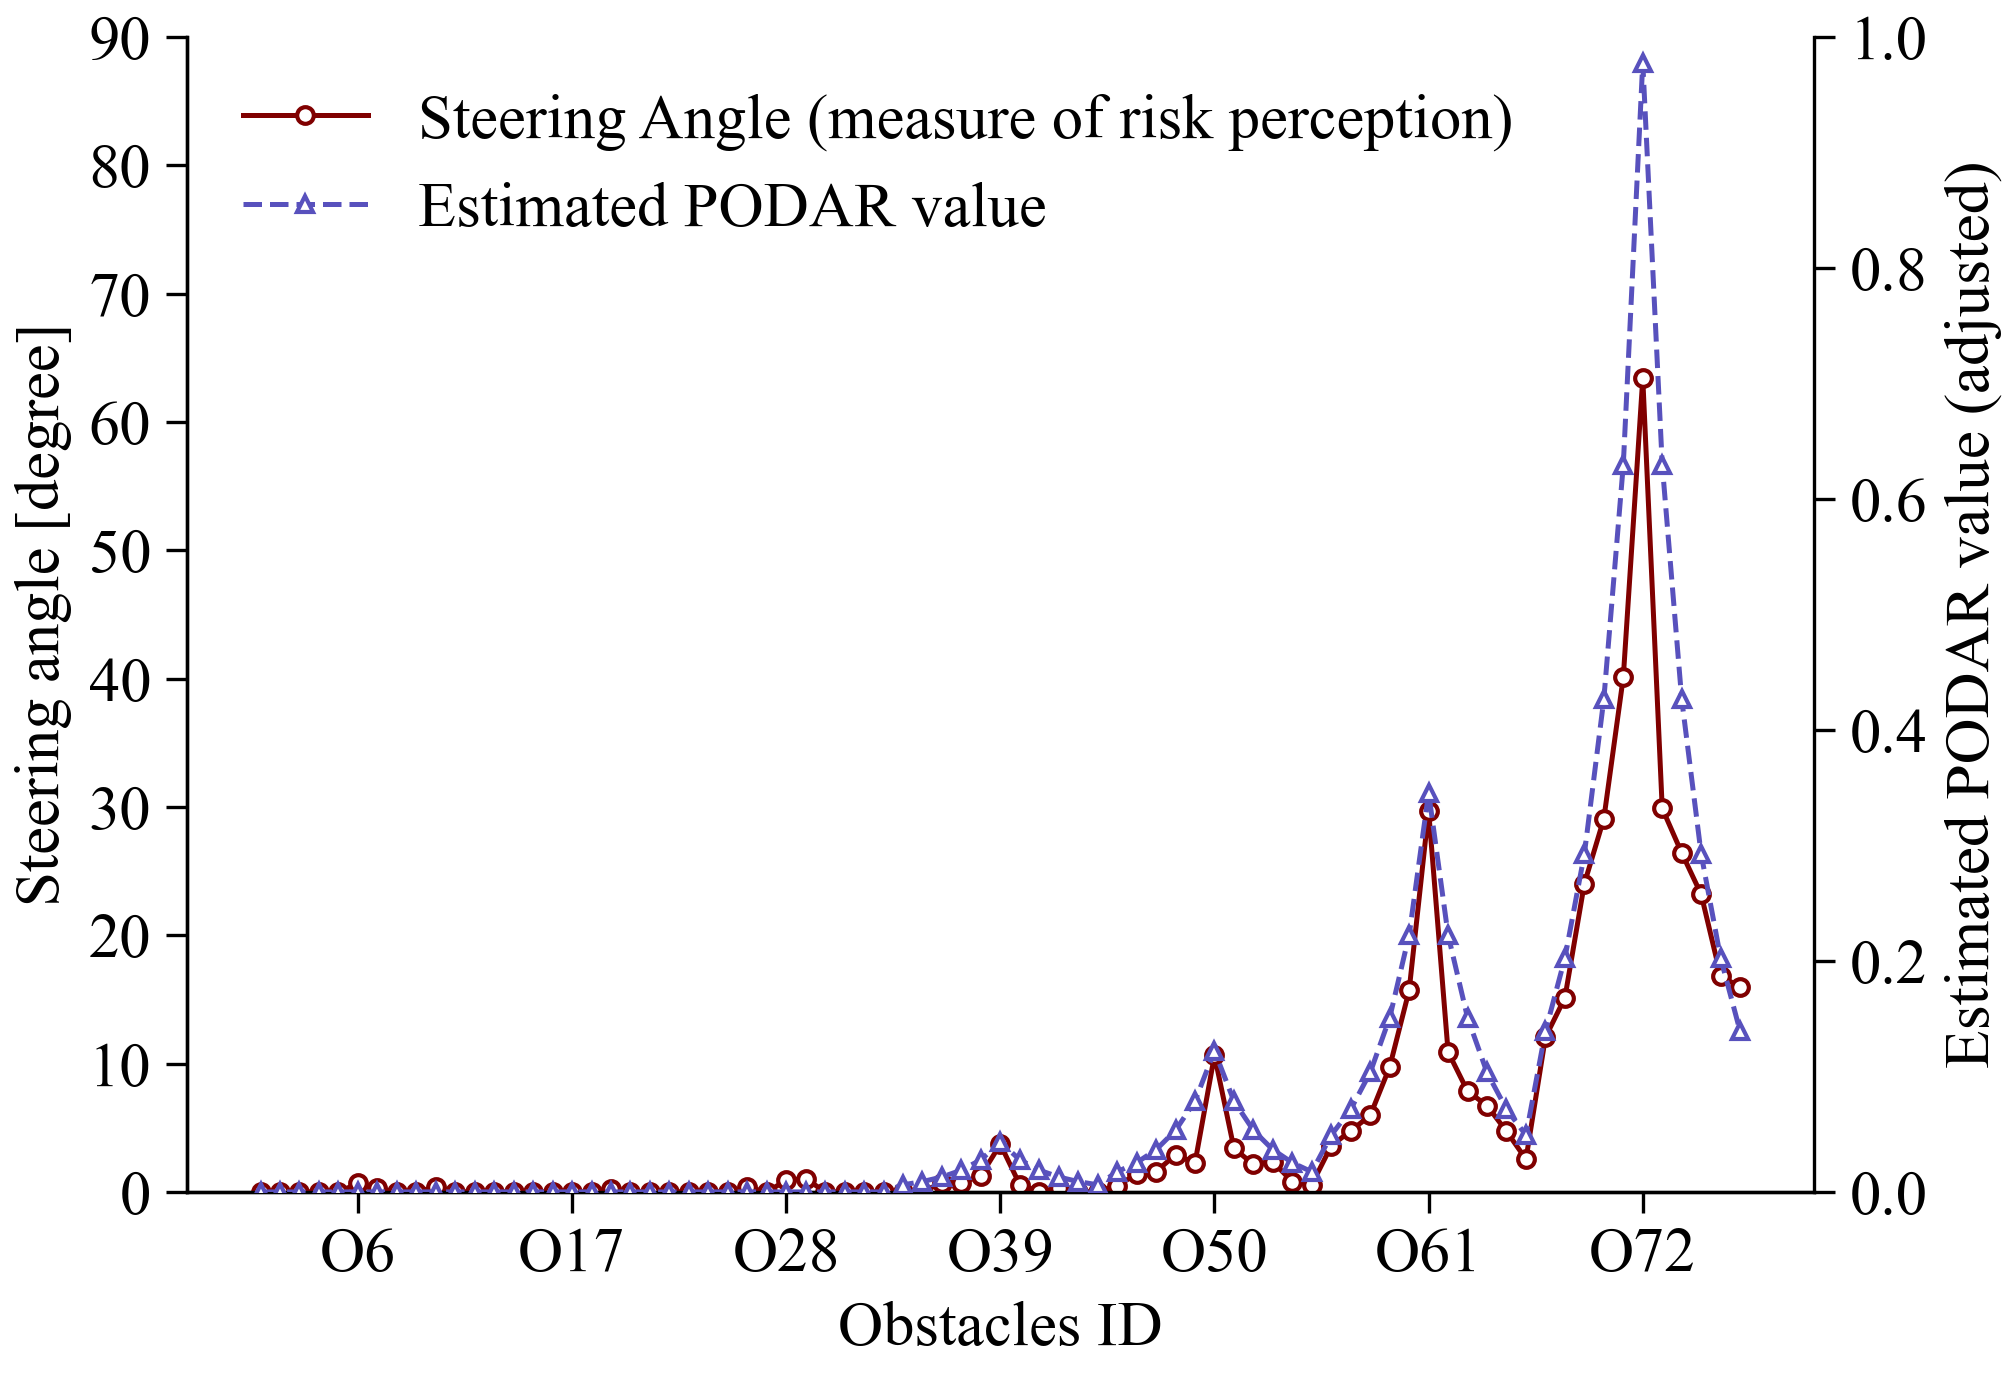

In [69]:
# Figure 3b
fig = plt.figure(figsize=(7,5))
line1, = plt.plot(np.arange(1, 78, 1), objective_data_by_obj, label='Steering Angle', zorder=100, marker='o', ms='4', c='#800000')
plt.ylabel('Steering angle [degree]', fontsize=15)
_x_ticks_label = ["O{}".format(i) for i in np.arange(6,73, 11)]
plt.xticks(np.arange(6,73, 11), _x_ticks_label, fontsize=15)
plt.ylim([0,90])
plt.xlabel('Obstacles ID', fontsize=15)
plt.yticks(fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.twinx()
line2, = plt.plot(np.arange(1, 78, 1), np.array(podar_est) * (0.0018 / 0.1), label='PODAR', linestyle='--', zorder=100, marker='^', ms='4', c='#5851bd')
plt.ylabel('Estimated PODAR value (adjusted)')
plt.yticks(fontsize=15)
plt.ylim([0,1])

plt.gca().spines['right'].set_visible(True)
plt.legend([line1, line2], ["Steering Angle (measure of risk perception)", 'Estimated PODAR value'], fontsize=15)


# 2 - Numerical experimet data generation and figures

## 2.1 - Longitudinal Motions

### 2.1.1 - Side-passing and car-following with constant speed (Fig. 4a)

data generation

In [70]:
def experiment_2(v):
    '''car-following and side-passing'''
    ego_init = [0., 0., 0., 3.5]
    obj_pos = [25., 0.0]
    risk_car_following, risk_side_passing = [], []
    TTC_cf = []

    state = []
    for loc in np.arange(0, 52, 1):
        vehicles1 = PODAR.Vehicles()
        vehicles1.set_ego(type='car', x0=ego_init[0], y0=ego_init[1], speed=v / 3.6, phi0=0.)
        vehicles1.add_obj(type='car', x0=obj_pos[0], y0=obj_pos[1], speed=0. / 3.6, phi0=0.)
        risk1, _, _ = vehicles1.estimate_risk()
        risk_car_following.append(risk1)
        TTC_cf.append((25-4.5-ego_init[0]) / (v / 3.6))

        vehicles2 = PODAR.Vehicles()
        vehicles2.set_ego(type='car', x0=ego_init[2], y0=ego_init[3], speed=v / 3.6, phi0=0.)
        vehicles2.add_obj(type='car', x0=obj_pos[0], y0=obj_pos[1], speed=0. / 3.6, phi0=0.)
        risk2, _, _ = vehicles2.estimate_risk()
        risk_side_passing.append(risk2)

        state.append(copy.deepcopy(ego_init))

        ego_init[0] = loc
        ego_init[2] = loc
    
    return (risk_car_following, risk_side_passing, np.array(state), TTC_cf)

risk_car_following30, risk_side_passing30, state30, TTC_cf30 = experiment_2(30.)
risk_car_following20, risk_side_passing20, state20, TTC_cf20 = experiment_2(20.)
risk_car_following15, risk_side_passing15, state15, TTC_cf10 = experiment_2(10.)

#### [-] Fig. 4a

Text(0.5, 0, 'X location of ego vehicle [m]')

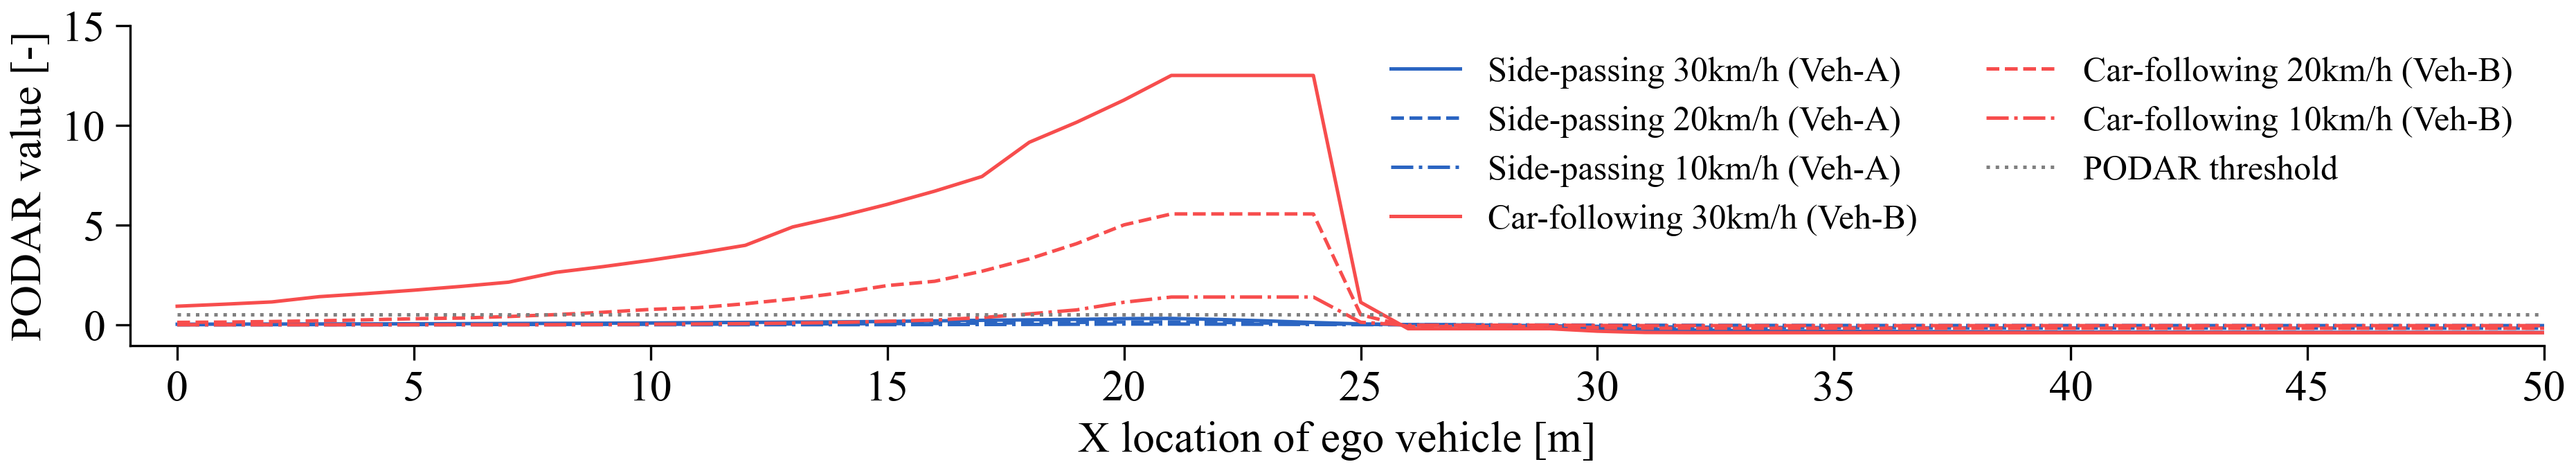

In [71]:
fig = plt.figure(figsize=(15,2))
plt.plot(state30[:, 0], risk_side_passing30, label='Side-passing 30km/h (Veh-A)', c=color_map1[0])
plt.plot(state20[:, 0], risk_side_passing20, label='Side-passing 20km/h (Veh-A)', c=color_map1[0], linestyle='--')
plt.plot(state15[:, 0], risk_side_passing15, label='Side-passing 10km/h (Veh-A)', c=color_map1[0], linestyle='-.')
plt.plot(state30[:, 0], risk_car_following30, label='Car-following 30km/h (Veh-B)', c=color_map1[1])
plt.plot(state20[:, 0], risk_car_following20, label='Car-following 20km/h (Veh-B)', c=color_map1[1], linestyle='--')
plt.plot(state15[:, 0], risk_car_following15, label='Car-following 10km/h (Veh-B)', c=color_map1[1], linestyle='-.')
ln, = plt.plot([0, 50], [0.5, 0.5], c='gray', linestyle=':', label='PODAR threshold')
plt.legend(ncol=2, fontsize=12)

plt.xticks(np.arange(0, 51, 5))
plt.yticks([0,5,10,15])
plt.xlim(-1, 50)
plt.ylabel('PODAR value [-]')
plt.xlabel('X location of ego vehicle [m]')


(13.5, 24.0)

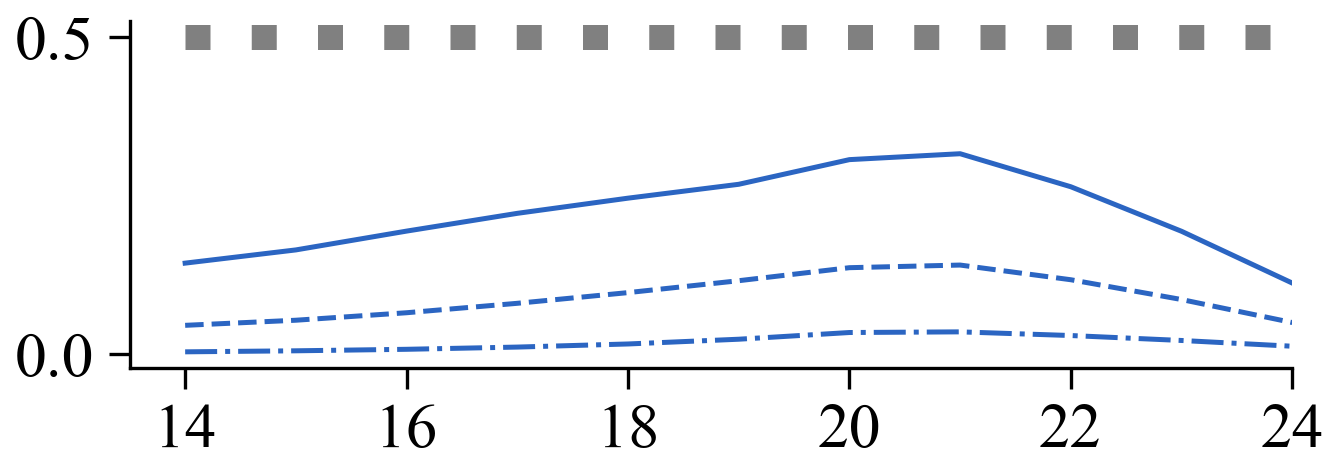

In [72]:
fig = plt.figure(figsize=(5,1.5))

plt.plot(state30[15:26, 0], risk_side_passing30[15:26], label='Side-passing 30km/h (Veh-A)', c=color_map1[0])
plt.plot(state20[15:26, 0], risk_side_passing20[15:26], label='Side-passing 20km/h (Veh-A)', c=color_map1[0], linestyle='--')
plt.plot(state15[15:26, 0], risk_side_passing15[15:26], label='Side-passing 15km/h (Veh-A)', c=color_map1[0], linestyle='-.')
plt.plot([14, 24], [0.5, 0.5], c='gray', linestyle=':', label='PODAR threshold', linewidth=6)
# plt.yticks([0.0, 0.25, 0.5])
# plt.ylim(-0.01, 0.5)
plt.xlim(13.5, 24)

### 2.1.2 - Dynamic car-following cases w/o a collision (Fig. 4b)

data generation

In [73]:
def SF_cal(vego, vobj, dis):
    mass = 1400
    Rego=1
    Robj=1
    k1, k2, k3 = 1.2, 1.2, 45
    K = 0.5
    h = 1
    DRego, DRobj = 0.5, 0.5
    alpha = 0.06
    M = mass * 1 * (1.566 * 10**(-14) * vobj** 6.687 + 0.3345)
    SPE = K * M * Rego * (1 + DRego) * ((h * Robj * M * (1 + DRobj) * k3) / ((k1 -1) * dis ** (k1 -1)) * (((k3-vobj)*np.cos(0)**(1-k1))/(k3-vobj)) ** (1/k1))
    E_grad = 1 if vego > vobj else -1
    SPE_dot = K * M * Rego * (1 + DRego) * ((h * Robj * M * (1 + DRobj) * k3 * (vego - vobj)) / ((k3 - vobj *np.cos(0)) * dis ** k1)) * E_grad
    DSI = alpha * SPE + (1 - alpha) * SPE_dot

    return DSI

def experiment_4():
    """Car following and compare with TTC, DRAC and SF
    """
    init_pos = [[0., 0.], [15.5, 0.]]  # ego pos, ov pos  
    init_speed = [10, 5]  # km/h
    min_a = -2.5
    ae = np.arange(0,min_a,-0.1).tolist() + [min_a] * 0 + np.arange(min_a, 0, 0.1).tolist() + [0] * 11 + np.arange(0, 2, 0.1).tolist() + [2] * 41
    aov = [0] * 55 + np.arange(0, 1, 0.1).tolist() + [1] * 45
    a = [ae, aov]  # ego acce, ov acce
    risks, ttc, drac, sf, drf = [], [], [], [], []
    colliede = []
    x1, y1, x2, y2 = [], [], [], []
    v, d, ve, vov = [], [], [], []
    media_variable = {}
    for i in range(0,110):      
        vehicles = PODAR.Vehicles()
        vehicles.set_ego(type='car', x0=init_pos[0][0], y0=init_pos[0][1], speed=init_speed[0], a0=a[0][i], phi0=0)
        vehicles.add_obj(type='car', x0=init_pos[1][0], y0=init_pos[1][1], speed=init_speed[1], a0=a[1][i], phi0=0)
        
        risk, _, rc = vehicles.estimate_risk()
        risks.append(risk)
        ttc.append(1 / ((init_pos[1][0] - init_pos[0][0] - 4.8) / (init_speed[0] - init_speed[1])))
        drac.append((init_speed[0] - init_speed[1]) ** 2 / abs(init_pos[1][0] - init_pos[0][0] - 4.8))
        sf.append(SF_cal(init_speed[0], init_speed[1], init_pos[1][0] - init_pos[0][0]-4.49))  # 1/2mv^2/r^2 +  1/2mv^2(v_r*cos)
        drf.append(0.0064 * (init_pos[1][0] - init_pos[0][0] - 4.49 - init_speed[0] * 3.5) ** 2 * 3500)
        
        d.append(init_pos[1][0] - init_pos[0][0] - 4.8)
        v.append(init_speed[0] - init_speed[1])
        ve.append(init_speed[0])
        vov.append(init_speed[1])
        colliede.append(rc)
        
        x1.append(init_pos[0][0])
        x2.append(init_pos[1][0])
        
        init_speed[0] += 0.1 * a[0][i]
        init_speed[1] += 0.1 * a[1][i]
        
        init_pos[0][0] += 0.1 * init_speed[0]
        init_pos[1][0] += 0.1 * init_speed[1]
        
        media_variable[i] = vehicles
        
    collided_info = (risks, x1, x2, (v, ve, vov), d, ttc, drac, sf, a, drf, media_variable, colliede)

    # ---------------
    init_pos = [[0., 0.], [20, 0.]]  # ego pos, ov pos 
    init_speed = [10, 5]  # km/h
    min_a = -2.5
    ae = np.arange(0,min_a,-0.1).tolist() + [min_a] * 0 + np.arange(min_a, 0, 0.1).tolist() + [0] * 11 + np.arange(0, 2, 0.1).tolist() + [2] * 41
    aov = [0] * 55 + np.arange(0, 1, 0.1).tolist() + [1] * 45
    a = [ae, aov]  # ego acce, ov acce
    risks, ttc, drac, sf, drf = [], [], [], [], []
    colliede = []
    x1, y1, x2, y2 = [], [], [], []
    v, d, ve, vov = [], [], [], []
    media_variable = {}
    for i in range(0,110):      
        vehicles = PODAR.Vehicles()
        vehicles.set_ego(type='car', x0=init_pos[0][0], y0=init_pos[0][1], speed=init_speed[0], a0=a[0][i], phi0=0)
        vehicles.add_obj(type='car', x0=init_pos[1][0], y0=init_pos[1][1], speed=init_speed[1], a0=a[1][i], phi0=0)
        
        risk, _, rc = vehicles.estimate_risk()
        risks.append(risk)
        ttc.append(1 / ((init_pos[1][0] - init_pos[0][0] - 4.8) / (init_speed[0] - init_speed[1])))
        drac.append((init_speed[0] - init_speed[1]) ** 2 / abs(init_pos[1][0] - init_pos[0][0] - 4.8))
        sf.append(SF_cal(init_speed[0], init_speed[1], init_pos[1][0] - init_pos[0][0]-4.49))  # 1/2mv^2/r^2 +  1/2mv^2(v_r*cos)
        drf.append(0.0064 * (init_pos[1][0] - init_pos[0][0] - 4.49 - init_speed[0] * 3.5) ** 2 * 3500)
        
        d.append(init_pos[1][0] - init_pos[0][0] - 4.8)
        v.append(init_speed[0] - init_speed[1])
        ve.append(init_speed[0])
        vov.append(init_speed[1])
        colliede.append(rc)
        
        x1.append(init_pos[0][0])
        x2.append(init_pos[1][0])
        
        init_speed[0] += 0.1 * a[0][i]
        init_speed[1] += 0.1 * a[1][i]
        
        init_pos[0][0] += 0.1 * init_speed[0]
        init_pos[1][0] += 0.1 * init_speed[1]
        
        media_variable[i] = vehicles
        
    collided_free_inf = (risks, x1, x2, (v, ve, vov), d, ttc, drac, sf, a, drf, media_variable, colliede)

    return collided_info, collided_free_inf


In [74]:
collided_info, collided_free_inf = experiment_4()
risks, x1, x2, v, d, ttc, drac, sf, a, drf, media_var, _ = collided_free_inf
risks_c, x1_c, x2_c, v_c, d_c, ttc_c, drac_c, sf_c, a_c, drf_c, media_var_c, collided_c = collided_info

#### [-] Fig.4b

Text(0, 0.5, 'DRF [-]')

<Figure size 3000x3000 with 0 Axes>

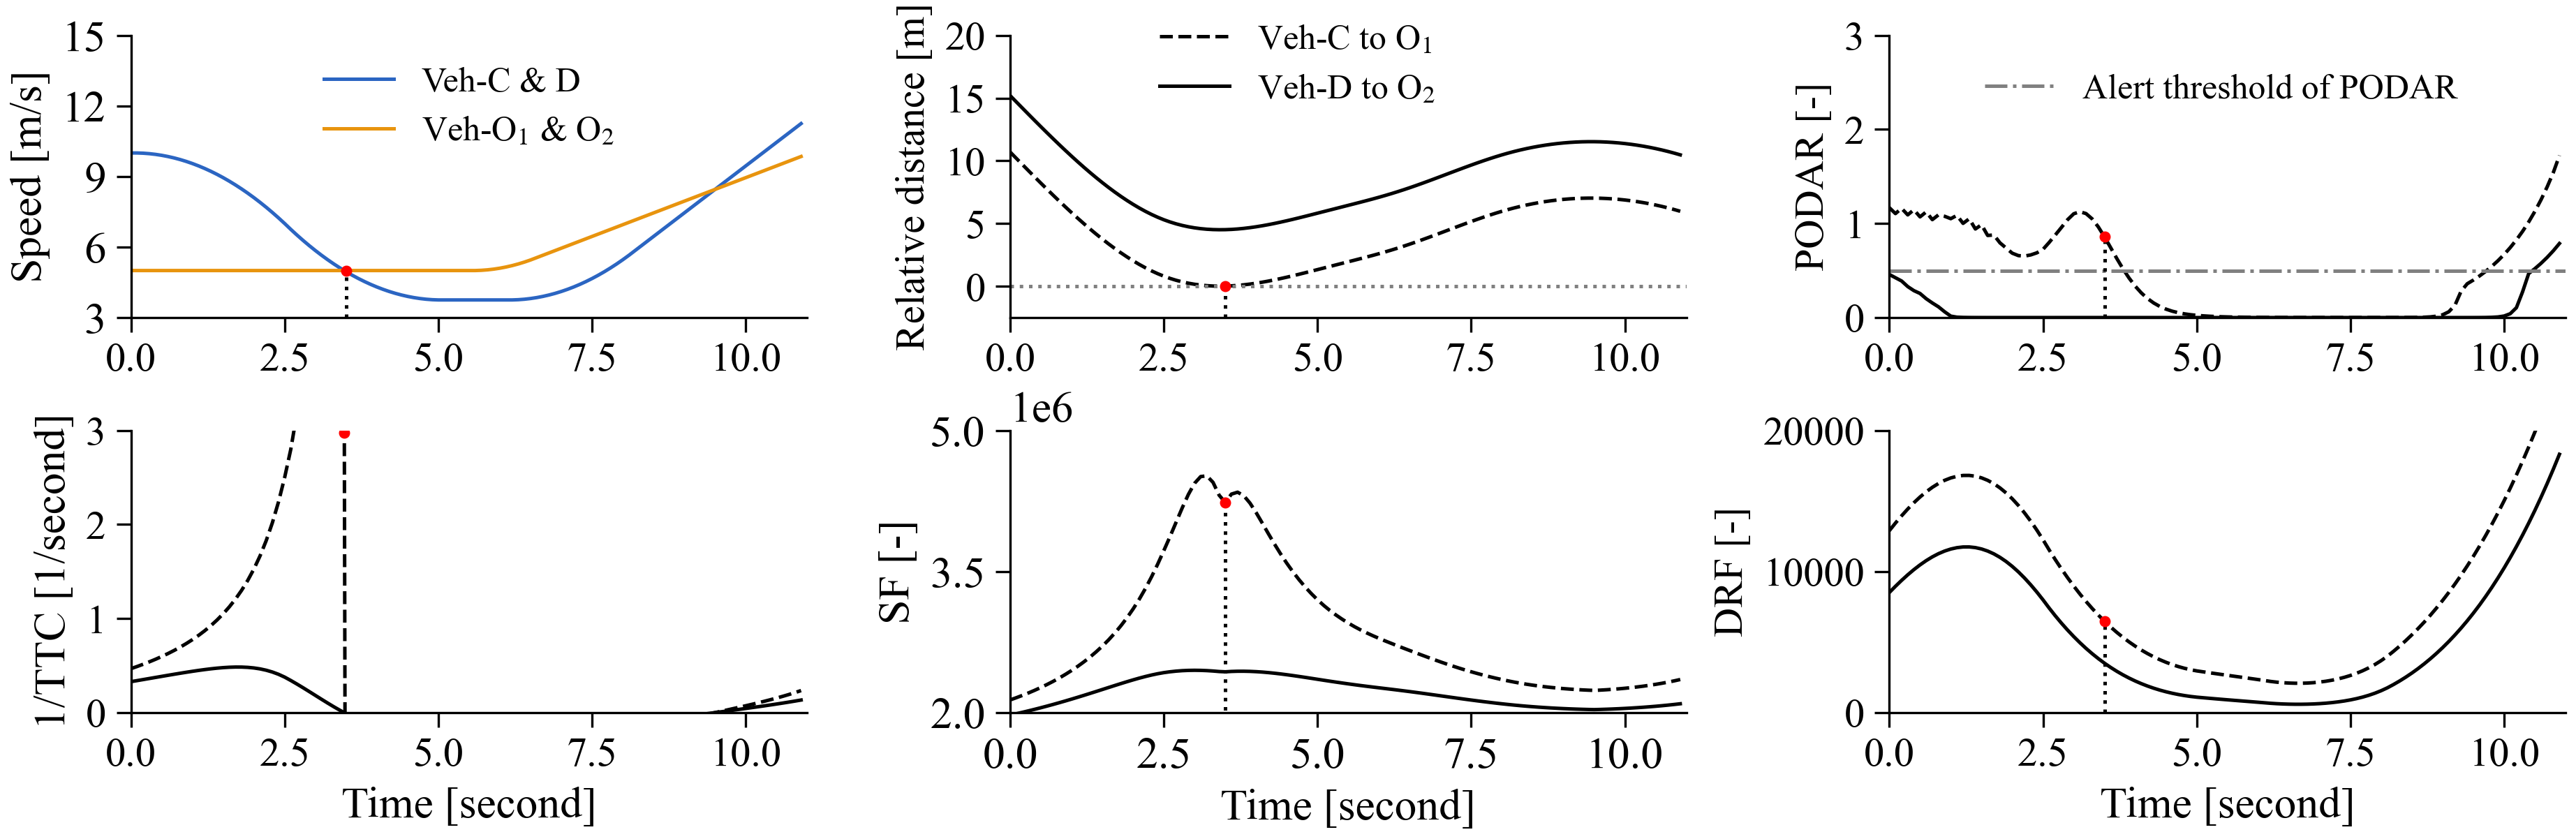

In [75]:
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(2,3,wspace=0.3,hspace=0.4)


ti = 11


zero_rv_min = np.where(np.array(v[0])<0)[0].min() / 10
zero_rv_max = np.where(np.array(v[0])<0)[0].max() / 10

plt.figure(figsize=(15,4.2))

plt.subplot(grid[0,0])
plt.plot(np.arange(0, ti, 0.1), v[1], label='Veh-C & D', c=color_map1[0])
plt.plot(np.arange(0, ti, 0.1), v[2], label='Veh-O$_1$ & O$_2$', c=color_map1[2])
plt.legend(fontsize=12, frameon=False)
plt.plot([zero_rv_min, zero_rv_min], [3, 5], c='black', linestyle=':')
plt.scatter(3.5, 5, c='red', label='Coll. Poi.', s=8, zorder=100)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.tick
plt.xlim([0,11])
plt.ylim([3,15])
plt.xticks(fontsize=14)
plt.yticks(np.arange(3, 16, 3))
plt.ylabel('Speed [m/s]')


plt.subplot(grid[0,1])
ln2, = plt.plot(np.arange(0, ti, 0.1), d, label='Veh-C 2 O$_1$', c='black')
ln1, = plt.plot(np.arange(0, ti, 0.1), d_c, label='Veh-C 2 O$_2$', c='black', linestyle='--')
plt.plot([zero_rv_min, zero_rv_min], [-2.5, 0], c='black', linestyle=':')
plt.plot([0, 12], [0, 0], c='gray', linestyle=':')
plt.scatter(3.5, d_c[35], c='red', label='Coll. Poi.', s=8, zorder=100)
plt.legend([ln1, ln2], ['Veh-C to O$_1$', 'Veh-D to O$_2$'], fontsize=12, frameon=False, loc=(0.2, 0.7))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim([0,11])
plt.ylim([-2.5,20])
plt.xticks(fontsize=14)
plt.yticks(np.arange(0, 21, 5), fontsize=14)
plt.ylabel('Relative distance [m]', fontsize=14)

plt.subplot(grid[0,2])
ln2, = plt.plot(np.arange(0, ti, 0.1), risks, label='PODAR', c='black')
ln1, = plt.plot(np.arange(0, ti, 0.1), risks_c, label='PODAR', c='black', linestyle='--')
ln3, = plt.plot([0,ti], [0.5, 0.5], label='Alert threshold', c='gray', linestyle='-.')
plt.plot([zero_rv_min, zero_rv_min], [0, risks_c[35]], c='black', linestyle=':')
plt.legend([ln3], ['Alert threshold of PODAR'], fontsize=12, frameon=False, loc=(0.12, 0.7))
plt.scatter(3.5, risks_c[35], c='red', s=8, zorder=100)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim([0,11])
plt.ylim([0,3])
plt.xticks(fontsize=14)
plt.yticks(np.arange(0, 4, 1), fontsize=14)
plt.ylabel('PODAR [-]', fontsize=14)

plt.subplot(grid[1,0])
ax2ln1 = plt.plot(np.arange(0, ti, 0.1), ttc, label='1/TTC [left y-axis]', c='black')
plt.plot(np.arange(0, ti, 0.1), ttc_c, label='1/TTC [left y-axis]', c='black', linestyle='--')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim([0,11])
plt.ylim([-1,2])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(3.465, 2.978, c='red', s=8, zorder=100)
plt.ylabel('1/TTC [1/second]')
plt.xlabel('Time [second]')
plt.ylim([0, 3])

plt.subplot(grid[1,1])
ln2, = plt.plot(np.arange(0, ti, 0.1), sf, label='SF', c='black')
ln1, = plt.plot(np.arange(0, ti, 0.1), sf_c, label='SF', c='black', linestyle='--')
plt.xlabel('Time [second]')
plt.plot([zero_rv_min, zero_rv_min], [0, sf_c[35]], c='black', linestyle=':')
plt.scatter(3.5, sf_c[35], c='red', s=8, zorder=100)
plt.ylabel('SF [-]')
plt.xlim([0,11])
plt.ylim([2*10**6,5*10**6])
plt.yticks([2*10**6, 3.5*10**6, 5*10**6])

plt.subplot(grid[1,2])
ln2, = plt.plot(np.arange(0, ti, 0.1), drf, label='DRF', c='black')
ln1, = plt.plot(np.arange(0, ti, 0.1), drf_c, label='DRF', c='black', linestyle='--')
plt.plot([zero_rv_min, zero_rv_min], [0, drf_c[35]], c='black', linestyle=':')
plt.scatter(3.5, drf_c[35], c='red', s=8, zorder=100)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim([0,11])
plt.xlabel('Time [second]')
plt.ylim([0,20000])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("DRF [-]", fontsize=14)

## 2.2 Lateral Conflicts

### 2.2.1 - 90-degree lateral conflicts

#### [-] Table in Fig. 5a

In [76]:
res = []

vehicles = PODAR.Vehicles()
vehicles.set_ego(type='car', x0=0., y0=-25., speed=30. / 3.6, phi0=np.pi / 2)
vehicles.add_obj(type='car', x0=15., y0=0, speed=30. / 3.6, phi0=np.pi)
vehicles.add_obj(type='car', x0=25., y0=0, speed=30. / 3.6, phi0=np.pi)
vehicles.estimate_risk()
res.append(['PODAR', 15, vehicles.obj[0].risk])
res.append(['PODAR', 25, vehicles.obj[1].risk])
res.append(['PET', 15, 25 / (30/3.6) - 15 / (30/3.6)])
res.append(['PET', 25, 0])
res.append(['SF', 15, SF_cal(30/3.6, 30/3.6, np.sqrt(25*25+15*15))])
res.append(['SF', 25, SF_cal(30/3.6, 30/3.6, np.sqrt(25*25+25*25))])
res.append(['DRF', 15, 0.0064 * (25 - 30/3.6*3.5)**2 * np.exp(-(25*25+15*15)**2/(2*(0.001*25 + 0.5)) / np.power(10,5)) * 3500])
res.append(['DRF', 25, 0.0064 * (25 - 30/3.6*3.5)**2 * np.exp(-(25*25+25*25)**2/(2*(0.001*25 + 0.5)) / np.power(10,5)) * 3500])

for i in res:
    print(i) 

['PODAR', 15, 0.006516335874578233]
['PODAR', 25, 1.906237286605673]
['PET', 15, 1.2000000000000002]
['PET', 25, 0]
['SF', 15, 1696651.9960612447]
['SF', 25, 1632464.1913175604]
['DRF', 15, 0.3994531825278908]
['DRF', 25, 0.00013400161433482796]


### 2.2.2 - Different conflict angles and object types

#### [-] Fig. 5b, left

In [85]:
from math import cos, sin, pi, atan2
def experiment_1(ego_state=0):
    '''
    conflicts from different angles and types and speed
    '''
    R = [15., 25., 35.]  # km/h
    ANGLE = [0., 45., 90., 135., 180., 225., 315]  # degree

    V_EGO = [0., 30.,]  # km/h
    V_CAR = [10., 30., 45.]  # km/h
    EGO_Y = [0., -25.]

    vehicles = PODAR.Vehicles()
    vehicles.set_ego(type='car', x0=0., y0=EGO_Y[ego_state], speed=V_EGO[ego_state] / 3.6, phi0=pi / 2)
    for r in R:
        for angle in ANGLE:
            angle = angle / 180 * pi
            a_ = pi + angle if angle < 0 else angle - pi
            for v_i in V_CAR:
                vehicles.add_obj(type='car', x0=r * cos(angle), y0=r * sin(angle), speed=v_i / 3.6, phi0=a_)

    vehicles.estimate_risk()
    res = vehicles.get_risk_in_stru()
    results = pd.DataFrame(res, columns=['ego_speed', 'r', 'type', 'phi', 'phi_de', 'x', 'y', 'ov_speed', 'ov_speed_km', 'risk', 'risk_curve', 'collided', 'rc'])

    return results, vehicles

results, vehicles = experiment_1(ego_state=1)


In [86]:
data = results
data.rename(columns={'x':'raw_x', 'y':'raw_y', 'risk': 'Risk', 'type': 'Type'}, inplace=True)
data['phi_de'] = np.round(data['phi_de'])
data['ov_speed_km'] = np.round(data['ov_speed_km'])
data['r'] = np.round(data['r'])

vehs = vehicles
ego = vehs.ego

import seaborn as sns
sns.set_theme(style="white",font='Times New Roman',font_scale=1.1)
use_data = data[(data['Type']=='car') & (data['ov_speed_km']!=10)]
use_data['Sur. Veh. V'] = use_data['ov_speed_km'].apply(lambda _: str(_) + 'km/h')
# use_data.reset_index(inplace=True)

v1, v2 = 30, 45
use_data['x'], use_data['y'] = 0, 0
use_data['x'][use_data['ov_speed_km']==v1] = use_data['raw_x'] + 1.2 * np.cos(use_data['phi'])
use_data['y'][use_data['ov_speed_km']==v1] = use_data['raw_y'] + 1.2 * np.sin(use_data['phi'])
use_data['x'][use_data['ov_speed_km']==v2] = use_data['raw_x'] - 1.2 * np.cos(use_data['phi'])
use_data['y'][use_data['ov_speed_km']==v2] = use_data['raw_y'] - 1.2 * np.sin(use_data['phi'])


C:\Users\Dell\AppData\Local\Temp\ipykernel_38992\1617117477.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Sur. Veh. V'] = use_data['ov_speed_km'].apply(lambda _: str(_) + 'km/h')
C:\Users\Dell\AppData\Local\Temp\ipykernel_38992\1617117477.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['x'], use_data['y'] = 0, 0
C:\Users\Dell\AppData\Local\Temp\ipykernel_38992\1617117477.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

C:\Users\Dell\AppData\Local\Temp\ipykernel_38992\2844239623.py:53: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  col_legend.legendHandles[0].set_markersize(10)
C:\Users\Dell\AppData\Local\Temp\ipykernel_38992\2844239623.py:54: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  col_legend.legendHandles[1].set_markersize(10)
C:\Users\Dell\AppData\Local\Temp\ipykernel_38992\2844239623.py:99: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  colli_legend.legendHandles[0].set_markersize(15)


(-39.82, 39.82, -38.56, 39.760000000000005)

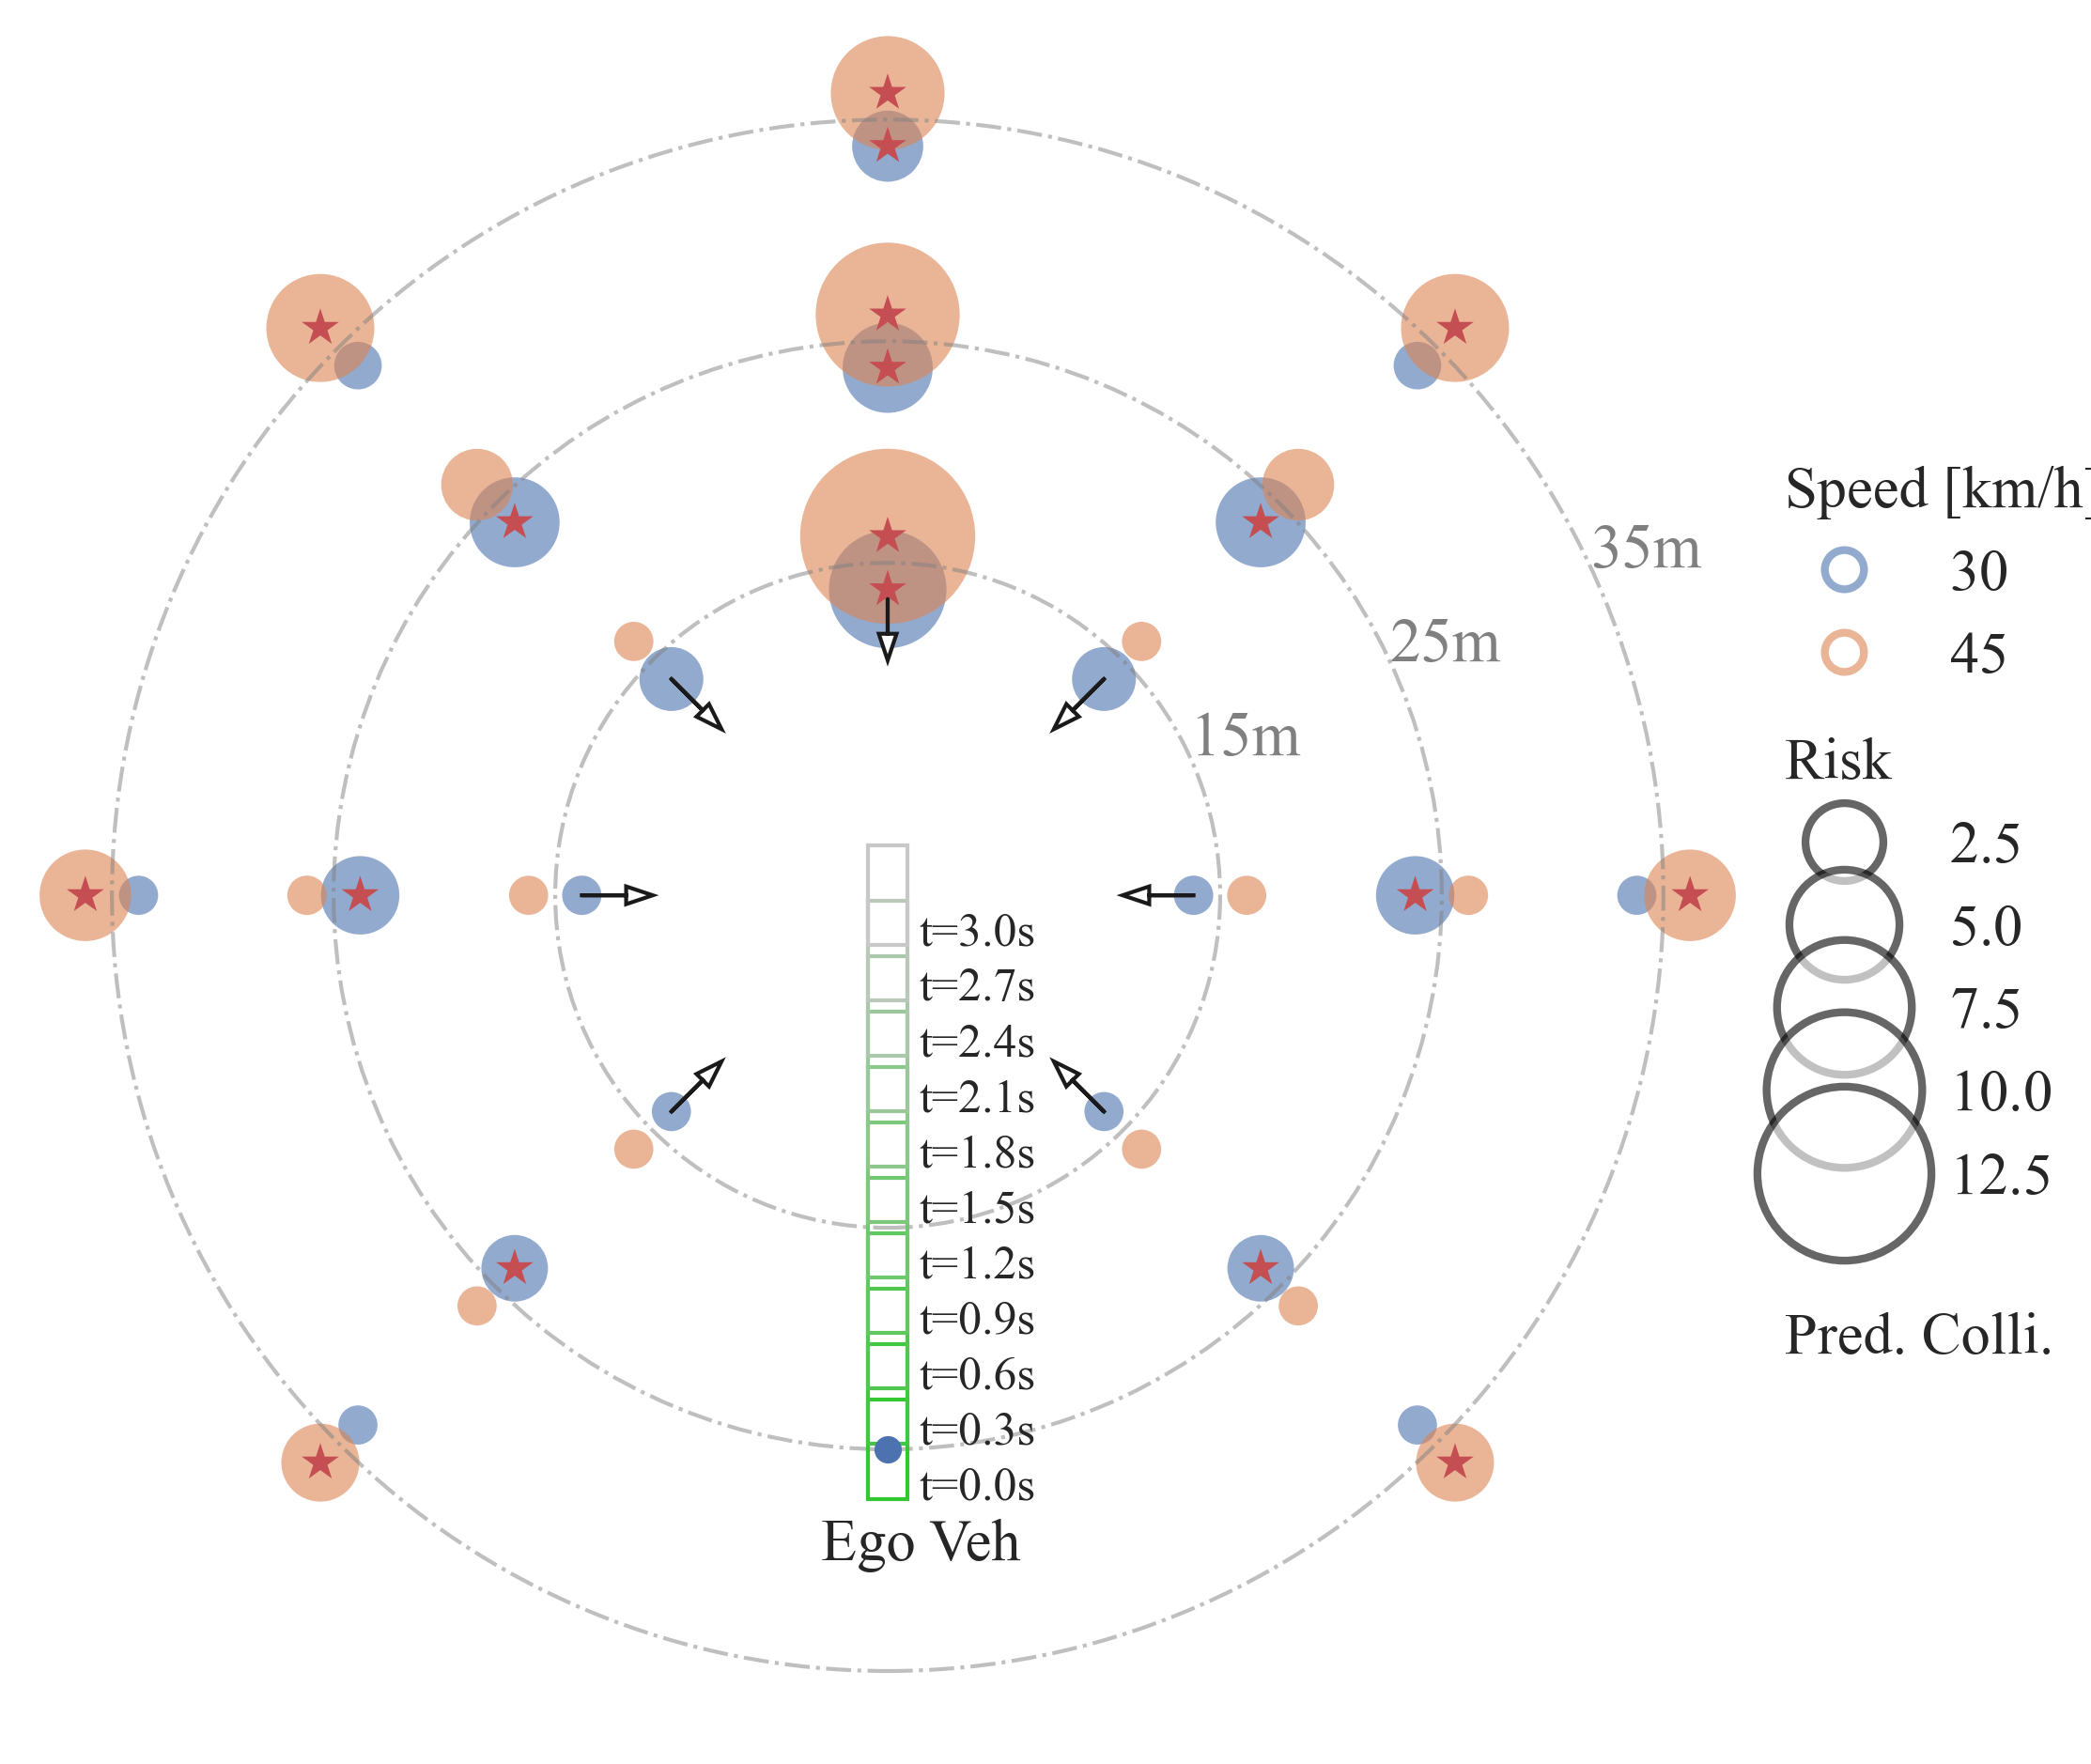

In [87]:
cmap = plt.cm.jet
c1 = [0.29803922, 0.44705882, 0.69019608, 0.6]
c2 = [0.86666667, 0.51764706, 0.32156863, 0.6]
cmaplist = [c1, c2]
mycmap11 = cmap.from_list('Custom cmap', cmaplist, cmap.N)
from matplotlib.patches import Ellipse, Circle
import matplotlib.patches as patches

def viz(obj, ax, ego_flag=0, offset=0):
    red, num = 50, 31
    ee = 0
    for tmp in range(num):
        if ee % 3 ==0: 
            w, l = obj.width, obj.length
            x0, y0, h0, rr = obj.x_pred[ee], obj.y_pred[ee] + offset, obj.phi_pred[ee], np.sqrt(w ** 2 + l ** 2) / 2
    
            betha = atan2(w / 2, l / 2)
            x = x0 - rr * cos(h0 + betha)
            y = y0 - rr * sin(h0 + betha) + offset
            if ego_flag == 1:
                ax.text(x+0.5, y, 't=' + str(ee / 10) + 's', fontsize=12)
            rect = patches.Rectangle((x, y), l, w, angle=h0 / pi * 180, fill=False,
                                     edgecolor=(red / 255, 200 / 255, red / 255),
                                     linewidth=1)
            ax.add_patch(rect)

            if ego_flag == 1 and ee == 0:
                xc, yc = x0, y0
        red += int(180 / num)
        if ego_flag==1 and ee == 0:            
            ax.text(x0-3, y0-5, 'Ego Veh', fontsize=15)        
        ee += 1
    if ego_flag == 1: ax.scatter(xc, yc)

fig = plt.figure(figsize=(8, 8))
# grid = plt.GridSpec(2,3,wspace=0.3,hspace=0.3, )
# ax = plt.subplot(grid[:,:2])
ax = fig.add_subplot()

max_risk = use_data['Risk'].max()
min_risk = use_data['Risk'].min()
scale_cof_max = 2000.
scale_cof_min = 100.  # scale_cof_max / max_risk * min_risk

size_plot = (use_data['Risk'] - min_risk) / (max_risk - min_risk) * (scale_cof_max - scale_cof_min) + scale_cof_min
sc = ax.scatter(use_data['x'].values, use_data['y'], s=size_plot, c=use_data['ov_speed_km'], alpha=0.6,
                edgecolor="none", linewidth=2, cmap=mycmap11) # vmin=30, vmax=45,

col_legend = ax.legend(*sc.legend_elements(), loc=(1, 0.6), title="Speed [km/h]", frameon=False, fontsize=15, title_fontsize=15)
col_legend._legend_box.align = "left"
# col_legend.legendHandles[0]._legmarker.set_markersize(10)
# col_legend.legendHandles[1]._legmarker.set_markersize(10)
col_legend.legendHandles[0].set_markersize(10)
col_legend.legendHandles[1].set_markersize(10)
ax.add_artist(col_legend)

kw1 = dict(prop="sizes", num=5, color='black', func=lambda s: (s - min_risk) / (scale_cof_max - scale_cof_min) * (max_risk - min_risk) + min_risk, linewidth=0) #  alpha=1
size_legend = ax.legend(*sc.legend_elements(**kw1), loc=(1, 0.30), title="Risk", frameon=False, fontsize=15, title_fontsize=15)
size_legend._legend_box.align = "left"
ax.add_artist(size_legend)

cir1 = Circle(xy = (0.0, 0.0), radius=15, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
cir2 = Circle(xy = (0.0, 0.0), radius=25, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
cir3 = Circle(xy = (0.0, 0.0), radius=35, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.text(15*cos(25/180*pi), 15*sin(25/180*pi), '15m',c='gray', fontsize=16)
ax.text(25*cos(25/180*pi), 25*sin(25/180*pi), '25m',c='gray', fontsize=16)
ax.text(35*cos(25/180*pi), 35*sin(25/180*pi), '35m',c='gray', fontsize=16)

viz(ego, ax, ego_flag=1)

for index, row in use_data.iterrows():
    if row['r'] == 15 and row['ov_speed_km'] == 30:
        c = 'k' # 'r' if row['collided'] == 60 / 3.6 else 'k'
        plt.arrow(row['x'], row['y'], np.cos(row['phi']) * 2, np.sin(row['phi']) * 2, width=0.003, head_width=0.8,
                  fc='white', ec=c)
    # if row['collided'] == 1:
    #     sc = plt.scatter(row['x'], row['y'], marker='*', c='red', s=100, alpha=0.5, linewidth=0)

from matplotlib.colors import ListedColormap
colours = ListedColormap(['r'])
collision_data = use_data[use_data['collided']==1]
sc_colli = ax.scatter(collision_data['x'], collision_data['y'], marker='*', c=[0] * collision_data.shape[0], s=100, alpha=1, linewidth=0, label='co', cmap=colours)

colli_legend = ax.legend(*sc_colli.legend_elements(), loc=(1, 0.16), title="Pred. Colli.", frameon=False, fontsize=15, title_fontsize=15)
colli_legend._legend_box.align = "left"
colli_legend.get_texts()[0].set_text('')  # or # colli_legend.get_texts()[0].set_color('white')
# colli_legend.legendHandles[0]._legmarker.set_markersize(15)
colli_legend.legendHandles[0].set_markersize(15)
# ax.add_artist(colli_legend)


plt.axis('equal')


#### [-] Fig. 5b, right

In [93]:
from math import cos, sin, pi, atan2
def experiment_1(ego_state=0):
    '''
    conflicts from different angles and types and speed
    '''
    R = [8.3, 15., 20.]  # km/h
    ANGLE = [0., 45., 90., 135., 180., 225., 315]  # degree

    V_EGO = [0., 30.,]  # km/h
    V_CAR = [10., 30., 45.]  # km/h
    V_BIC = [5., 10.]  # km/h
    EGO_Y = [0., -25.]

    vehicles = PODAR.Vehicles()
    vehicles.set_ego(type='car', x0=0., y0=EGO_Y[ego_state], speed=V_EGO[ego_state] / 3.6, phi0=pi / 2)
    for r in R:
        for angle in ANGLE:
            angle = angle / 180 * pi
            a_ = pi + angle if angle < 0 else angle - pi
            for v_i in V_CAR:
                vehicles.add_obj(type='car', x0=r * cos(angle), y0=r * sin(angle), speed=v_i / 3.6, phi0=a_)
            # if angle * 180 / pi > 180: continue
            for v_i in V_BIC:
                vehicles.add_obj(type='bic', x0=r * cos(angle), y0=r * sin(angle), speed=v_i / 3.6, phi0=a_)

    vehicles.estimate_risk()
    res = vehicles.get_risk_in_stru()
    results = pd.DataFrame(res, columns=['ego_speed', 'r', 'type', 'phi', 'phi_de', 'x', 'y', 'ov_speed', 'ov_speed_km', 'risk', 'risk_curve', 'collided', 'rc'])

    return results, vehicles

results, vehicles = experiment_1(ego_state=1)


data = results
data.rename(columns={'x':'raw_x', 'y':'raw_y', 'risk': 'Risk', 'type': 'Type'}, inplace=True)
data['phi_de'] = np.round(data['phi_de'])
data['ov_speed_km'] = np.round(data['ov_speed_km'])
data['r'] = np.round(data['r'])

vehs = vehicles
ego = vehs.ego

use_data1 = data[(data['ov_speed_km']==10)] # & (data['phi']<=0)]
use_data2 = data[(data['Type']=='car') & (data['ov_speed_km']==10)] # & (data['phi']<=0)]
use_data = pd.concat((use_data1, use_data2))

# use_data.reset_index(inplace=True)
print(data.shape, use_data.shape)
type1, type2 = 'car', 'bic'
v0, v1 = 10, 30
use_data['x'], use_data['y'] = 0, 0
use_data['x'][use_data['Type']==type1] = use_data['raw_x'] + 0.8 * np.cos(use_data['phi'])
use_data['y'][use_data['Type']==type1] = use_data['raw_y'] + 0.8 * np.sin(use_data['phi'])
use_data['x'][use_data['Type']==type2] = use_data['raw_x'] - 0.8 * np.cos(use_data['phi'])
use_data['y'][use_data['Type']==type2] = use_data['raw_y'] - 0.8 * np.sin(use_data['phi'])

# use_data['Type-Speed'] = use_data['Type'].str.cat(use_data['ov_speed_km'].apply(lambda x: str(x) + 'km/h'), sep='-')
use_data['color'] = None
use_data['color'][(use_data['Type']==type2) & (use_data['ov_speed_km']==v0)] = 0
use_data['color'][(use_data['Type']==type1) & (use_data['ov_speed_km']==v0)] = 1

print(use_data['color'].unique())

(105, 13) (63, 13)
[1 0]


C:\Users\Dell\AppData\Local\Temp\ipykernel_38992\1731908951.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['x'][use_data['Type']==type1] = use_data['raw_x'] + 0.8 * np.cos(use_data['phi'])
C:\Users\Dell\AppData\Local\Temp\ipykernel_38992\1731908951.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['y'][use_data['Type']==type1] = use_data['raw_y'] + 0.8 * np.sin(use_data['phi'])
C:\Users\Dell\AppData\Local\Temp\ipykernel_38992\1731908951.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

C:\Users\Dell\AppData\Local\Temp\ipykernel_38992\286739556.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  col_legend.legendHandles[0].set_markersize(10)
C:\Users\Dell\AppData\Local\Temp\ipykernel_38992\286739556.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  col_legend.legendHandles[1].set_markersize(10)
C:\Users\Dell\AppData\Local\Temp\ipykernel_38992\286739556.py:70: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  colli_legend.legendHandles[0].set_markersize(15)
C:\Users\Dell\AppData\Local\Temp\ipykernel_38992\286739556.py:71: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 a

(-27.5, 27.5, -29.8625, 27.6125)

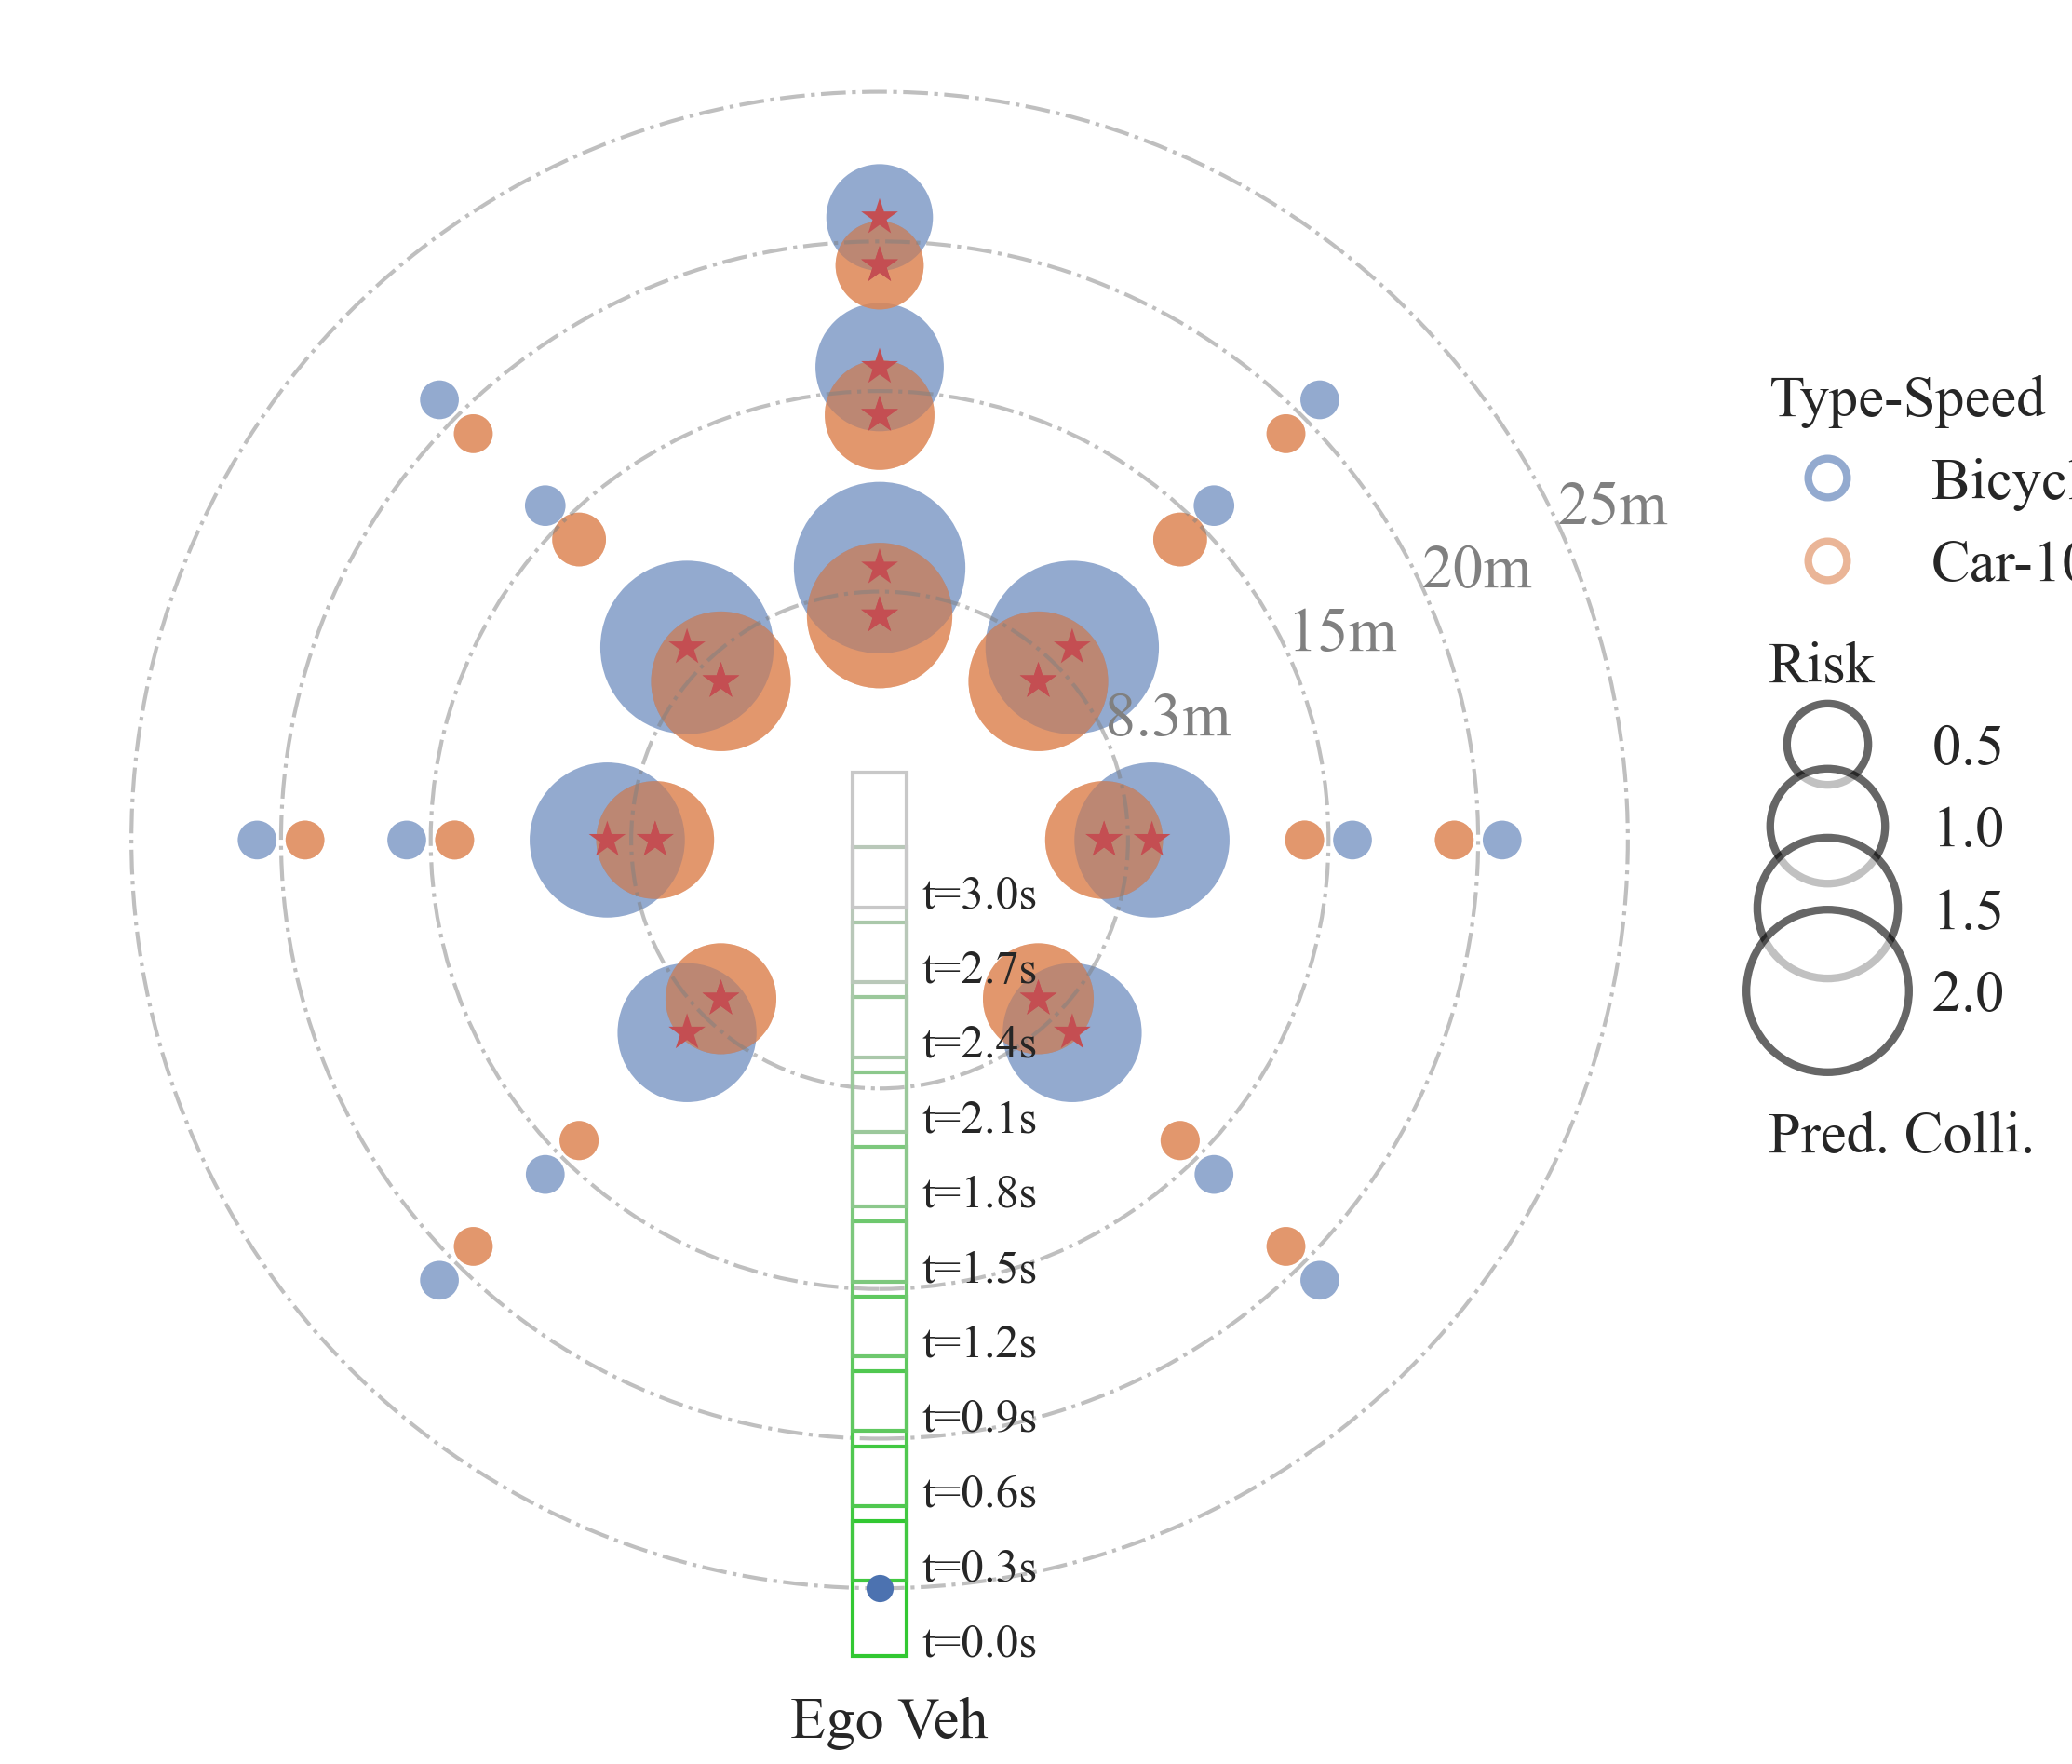

In [100]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

max_risk = use_data['Risk'].max()
min_risk = use_data['Risk'].min()
scale_cof_max = 2000.
scale_cof_min = 100.  # scale_cof_max / max_risk * min_risk

size_plot = (use_data['Risk'] - min_risk) / (max_risk - min_risk) * (scale_cof_max - scale_cof_min) + scale_cof_min
sc = ax.scatter(use_data['x'], use_data['y'], s=size_plot, c=use_data['color'], alpha=0.6,
                edgecolor="none", linewidth=2, cmap=mycmap) # vmin=30, vmax=45,

col_legend = ax.legend(*sc.legend_elements(), loc=(1, 0.65), title="Type-Speed", frameon=False, fontsize=15, title_fontsize=15)
col_legend._legend_box.align = "left"
# col_legend.legendHandles[0]._legmarker.set_markersize(10)
# col_legend.legendHandles[1]._legmarker.set_markersize(10)
# col_legend.legendHandles[2]._legmarker.set_markersize(10)
col_legend.legendHandles[0].set_markersize(10)
col_legend.legendHandles[1].set_markersize(10)
# col_legend.legendHandles[2].set_markersize(10)
col_legend.get_texts()[0].set_text('Bicycle-10km/h')
col_legend.get_texts()[1].set_text('Car-10km/h')
# col_legend.get_texts()[2].set_text('Car-30km/h')
ax.add_artist(col_legend)

kw1 = dict(prop="sizes", num=5, color='black', func=lambda s: (s - min_risk) / (scale_cof_max - scale_cof_min) * (max_risk - min_risk) + min_risk, linewidth=0) #  alpha=1
size_legend = ax.legend(*sc.legend_elements(**kw1), loc=(1, 0.4), title="Risk", frameon=False, fontsize=15, title_fontsize=15)
size_legend._legend_box.align = "left"
ax.add_artist(size_legend)

cir1 = Circle(xy = (0.0, 0.0), radius=8.3, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
cir2 = Circle(xy = (0.0, 0.0), radius=15, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
cir3 = Circle(xy = (0.0, 0.0), radius=20, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
cir4 = Circle(xy = (0.0, 0.0), radius=25, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)
ax.add_patch(cir4)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.text(8.3*cos(25/180*pi), 8.3*sin(25/180*pi), '8.3m',c='gray', fontsize=16)
ax.text(15*cos(25/180*pi), 15*sin(25/180*pi), '15m',c='gray', fontsize=16)
ax.text(20*cos(25/180*pi), 20*sin(25/180*pi), '20m',c='gray', fontsize=16)
ax.text(25*cos(25/180*pi), 25*sin(25/180*pi), '25m',c='gray', fontsize=16)

viz(ego, ax, ego_flag=1)

for index, row in use_data.iterrows():
    if row['r'] == 15 and row['ov_speed_km'] == 30 and row['Type'] == 'car':
        c = 'k' # 'r' if row['collided'] == 60 / 3.6 else 'k'
        ax.arrow(row['x'], row['y'], np.cos(row['phi']) * 2, np.sin(row['phi']) * 2, width=0.003, head_width=0.8,
                  fc='white', ec=c)
    # if row['collided'] == 1:
    #     sc = plt.scatter(row['x'], row['y'], marker='*', c='red', s=100, alpha=0.5, linewidth=0)

from matplotlib.colors import ListedColormap
colours = ListedColormap(['r'])
collision_data = use_data[use_data['collided']==1]
sc_colli = ax.scatter(collision_data['x'], collision_data['y'], marker='*', c=[0] * collision_data.shape[0], s=100, alpha=1, linewidth=0, label='co', cmap=colours)

colli_legend = ax.legend(*sc_colli.legend_elements(), loc=(1, 0.27), title="Pred. Colli.", frameon=False, fontsize=15, title_fontsize=15)
colli_legend._legend_box.align = "left"
colli_legend.get_texts()[0].set_text('')  # or # colli_legend.get_texts()[0].set_color('white')
colli_legend.legendHandles[0].set_markersize(15)
colli_legend.legendHandles[0].set_markersize(15)

plt.axis('equal')

# 3 - Multiple surrounding vehicles in a intersection, Simulation

Please refer to "render.py" in the root directory. You can directly execute this py to see the whole left-turn process.

If you want to save frames showed in the Fig. 6 in the manuscript, just Uncomment line 494-495:

```
if round(time, 1) in save_time:
    plt.savefig(r'dyn_pics/' + str(round(time, 1)) + '.svg',dpi=600)
```

# 4 - Application in InD Dataset

Please directly run the code in the PODAR.py to get the whole process in Fig. 7.

Or you can see the attacthed mp4 file